In [3]:
import pandas as pd

df = pd.read_csv('../data/training.csv')
df = df.set_index('label')


print("Group by and display count for each category")

print("There are 12 categories of complaints")


df.groupby(df.index).count()


print("Make a dataset for training")

print('''
We are sampling 4000 entries per category, 
thus minority classes are oversampled, ensuring that there is no imbalance in the dataset

# Q. What is the need to do this? 
# A. To resolve the bottleneck of having too few entries for some classes ~ 1400 
#    as well as too much for some classes ~16k. I have taken the number of samples as tunable,
#    and I arrived at the number 4000 just by hit and trial.

# STATE is used for producing replicable results

''')

Group by and display count for each category
There are 12 categories of complaints
Make a dataset for training

We are sampling 4000 entries per category, 
thus minority classes are oversampled, ensuring that there is no imbalance in the dataset

# Q. What is the need to do this? 
# A. To resolve the bottleneck of having too few entries for some classes ~ 1400 
#    as well as too much for some classes ~16k. I have taken the number of samples as tunable,
#    and I arrived at the number 4000 just by hit and trial.

# STATE is used for producing replicable results




In [4]:
df_for_training = pd.DataFrame()
SAMPLES = 5000
STATE = 0

for i in list(set(df.index)):
    df_for_training = df_for_training.append(df.loc[i].sample(n=SAMPLES,random_state=STATE,replace=True))

df_for_training['class_label'] = df_for_training.index.factorize()[0]


print("Since the classes are now numbered, I am storing this in a mapper.")


import json

mapper_df = df_for_training[['class_label']].reset_index().groupby('label').mean()
mapper = mapper_df.to_dict()['class_label']
mapper = dict([(v, k) for k, v in mapper.items()])
mapper = dict(sorted(mapper.items()))

with open("../data/mapper.json", "w") as outfile:  
    json.dump(mapper, outfile) 

df_for_training = df_for_training.dropna()

print(mapper)

Since the classes are now numbered, I am storing this in a mapper.
{0: 'Electrical', 1: 'Traffic', 2: 'Water Supply', 3: 'Garden', 4: 'Health', 5: 'Road', 6: 'Stray Dogs', 7: 'Property Tax', 8: 'Encroachment', 9: 'Garbage', 10: 'Drainage', 11: 'Building Permission'}


Let's begin training the model, now that we have our data
importing libraries for the model


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manpreet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initializing the stemmer, stopwords and the vectorizer
 Creating the input set by renaming columns and shuffling
Creating the train-test split


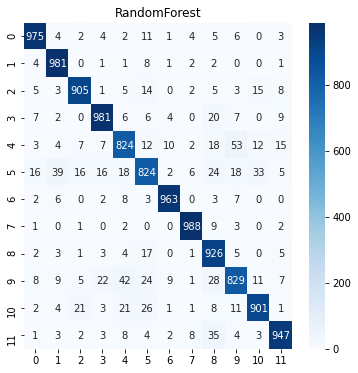

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1017
           1       0.93      0.98      0.95      1001
           2       0.94      0.94      0.94       966
           3       0.94      0.94      0.94      1042
           4       0.88      0.85      0.86       967
           5       0.87      0.81      0.84      1017
           6       0.97      0.97      0.97       994
           7       0.97      0.98      0.98      1006
           8       0.86      0.96      0.90       967
           9       0.88      0.83      0.85       995
          10       0.92      0.90      0.91      1000
          11       0.94      0.93      0.94      1020

    accuracy                           0.92     11992
   macro avg       0.92      0.92      0.92     11992
weighted avg       0.92      0.92      0.92     11992



In [5]:
print("Let's begin training the model, now that we have our data") 


print("importing libraries for the model")

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC


import re
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt





print("Initializing the stemmer, stopwords and the vectorizer")

stemmer = PorterStemmer()
words = stopwords.words("english")
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True)




print("Creating the input set by renaming columns and shuffling")
      
X = df_for_training.copy() # Deep copy
X.columns = ['text','label']
X.index.name = None
X = X.reset_index()
X = X[['text','label']]
X = X.sample(frac=1)


print("Creating the train-test split") 
X['cleaned'] = X['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

x = X['cleaned']
y = X['label']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
Y_test = np.array(y_test)


print("Initializing the models")
models = {
            'RandomForest' : RandomForestClassifier(n_estimators=10,n_jobs=4,random_state=STATE),
#             'LinearSVC' : LinearSVC(),
#             'MultinomialNB' : MultinomialNB(),
#             'LogisticRegression' : LogisticRegression(max_iter=200,random_state=STATE),
#             'RBF_SVC' : SVC(probability=True,random_state=STATE)
#             'GBDT' : GradientBoostingClassifier()
         }




accuracies = {}
for model_name in list(models.keys()):
    pipeline = Pipeline([('vect', vectorizer),
                         ('clf', models[model_name])])

    model = pipeline.fit(X_train, y_train)
    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)
        
    
    plt.figure(figsize=(6,6))
    plt.title(model_name)
    sns.heatmap(confusion_matrix(Y_test, model.predict(X_test)),annot=True,fmt='',cmap='Blues')
    plt.show()
    
    accuracies[model_name] = "{:.2f}".format(model.score(X_test, Y_test) * 100)
    print(classification_report(Y_test, model.predict(X_test)))